# Use `Folder` for Customs Datasets

# Installing Anomalib

The easiest way to install anomalib is to use pip. You can install it from the command line using the following command:


In [ ]:
%pip install anomalib

## Setting up the Dataset Directory

This cell is to ensure we change the directory to have access to the datasets.


In [1]:
from pathlib import Path

# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = Path.cwd().parents[1] / "datasets" / "conform_3"
print(dataset_root)

/home/shiva/Documents/code/anomalib/datasets/conform_3


## Use Folder Dataset (for Custom Datasets) via API

Here we show how one can utilize custom datasets to train anomalib models. A custom dataset in this model can be of the following types:

- A dataset with good and bad images.
- A dataset with good and bad images as well as mask ground-truths for pixel-wise evaluation.
- A dataset with good and bad images that is already split into training and testing sets.

To experiment this setting we use the [conform_3](https://www.dropbox.com/scl/fo/xamjicjg33astgnecdlxo/AL-4XFkkvpkowyKzylFie6k?rlkey=fy6f8ldzg494v470061ayxtf7&st=ukwz00yu&dl=0) dataset. For the rest of the tutorial, we assume that the dataset is downloaded and extracted to `../datasets`, located in the `anomalib` directory.


In [2]:
# flake8: noqa
import numpy as np
from PIL import Image
from torchvision.transforms.v2 import Resize, Compose, Lambda, ColorJitter, ToTensor, ConvertImageDtype, ToPILImage
import torchvision.transforms.v2.functional as F
import matplotlib.pyplot as plt
import torch

from anomalib.data.image.folder import Folder, FolderDataset
from anomalib import TaskType

### DataModule

Similar to how we created the datamodules for existing benchmarking datasets in the previous tutorials, we can also create an Anomalib datamodule for our custom conform_3 dataset.

In addition to the root folder of the dataset, we now also specify which folder contains the normal images, and which folder contains the anomalous images.


In [3]:
folder_datamodule = Folder(
    name="conform_3",
    root=dataset_root,
    normal_dir="good",
    abnormal_dir="bad",
    task=TaskType.CLASSIFICATION,
    image_size=(256, 256),
)
folder_datamodule.setup()

In [4]:
# Train images
i, data = next(enumerate(folder_datamodule.train_dataloader()))
print(data.keys(), data["image"].shape)

dict_keys(['image_path', 'label', 'image']) torch.Size([32, 3, 256, 256])


In [5]:
print(data['label'].size(), data['label'])

torch.Size([32]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [6]:
# Test images
i, data = next(enumerate(folder_datamodule.test_dataloader()))
print(data.keys(), data["image"].shape)

dict_keys(['image_path', 'label', 'image']) torch.Size([32, 3, 256, 256])


In [7]:
print(data['label'].size(), data['label'])

torch.Size([32]) tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


As can be seen above, creating the dataloaders are pretty straghtforward, which could be directly used for training/testing/inference. We could visualize samples from the dataloaders as well.


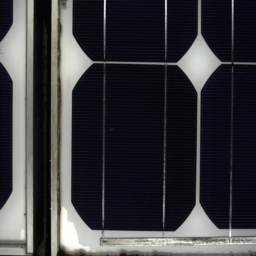

In [8]:
img = F.to_pil_image(data["image"][0].clone())

Image.fromarray(np.array(img))

`Folder` data module offers much more flexibility cater all different sorts of needs. Please refer to the documentation for more details.


### Torch Dataset

As in earlier examples, we can also create a standalone PyTorch dataset instance.


In [9]:
FolderDataset

anomalib.data.image.folder.FolderDataset

We can add some transforms that will be applied to the images using torchvision. Let's add a transform that resizes the 
input image to 256x256 pixels.

In [10]:
image_size = (256, 256)
contrast_factor = 1.2
#brightness_factor = 0.5
gamma = 0.5
saturation_factor = 1.2
transform = Compose([
    ToTensor(),
    Resize(image_size, antialias=True),
    Lambda(lambda img: F.adjust_contrast_image(img, contrast_factor)),
    #Lambda(lambda img: F.equalize(img)),
    #Lambda(lambda img: F.adjust_brightness(img, brightness_factor)),
    Lambda(lambda img: F.adjust_saturation(img,saturation_factor)),
    Lambda(lambda img: F.adjust_gamma(img, gamma)),
    #ConvertImageDtype(torch.uint8),

])

/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


#### Classification Task


In [11]:
folder_dataset_classification_train = FolderDataset(
    name="conform_3",
    normal_dir=dataset_root / "good",
    abnormal_dir=dataset_root / "bad",
    split="train",
    transform=transform,
    task=TaskType.CLASSIFICATION,
)
folder_dataset_classification_train.samples.head()

,image_path,label,label_index,mask_path,split
0,/home/shiva/Documents/code/anomalib/datasets/c...,DirType.NORMAL,0,,Split.TRAIN
1,/home/shiva/Documents/code/anomalib/datasets/c...,DirType.NORMAL,0,,Split.TRAIN
2,/home/shiva/Documents/code/anomalib/datasets/c...,DirType.NORMAL,0,,Split.TRAIN
3,/home/shiva/Documents/code/anomalib/datasets/c...,DirType.NORMAL,0,,Split.TRAIN
4,/home/shiva/Documents/code/anomalib/datasets/c...,DirType.NORMAL,0,,Split.TRAIN


/home/shiva/Documents/code/anomalib/datasets/conform_3/good/Cam 0_12296.jpg


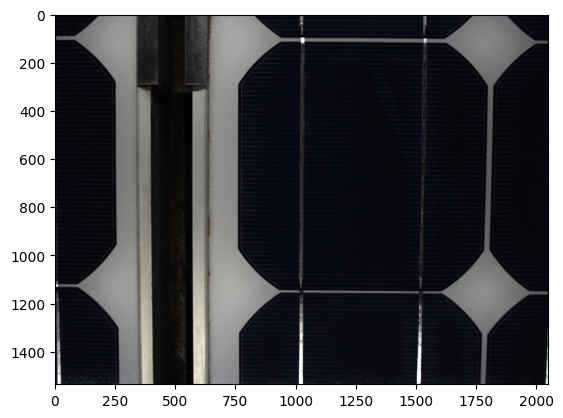

In [12]:
%matplotlib inline
# Visualize train samples
img_path = folder_dataset_classification_train.samples.iloc[0,0]
print(img_path)
image = Image.open(img_path)
#image.show()
#plt.axis('off')
plt.imshow(image)

Let's look at the first sample in the dataset.


In [13]:
data = folder_dataset_classification_train[0]
print(data.keys(), data["image"].shape)

dict_keys(['image_path', 'label', 'image']) torch.Size([3, 256, 256])


(1536, 2048, 3)


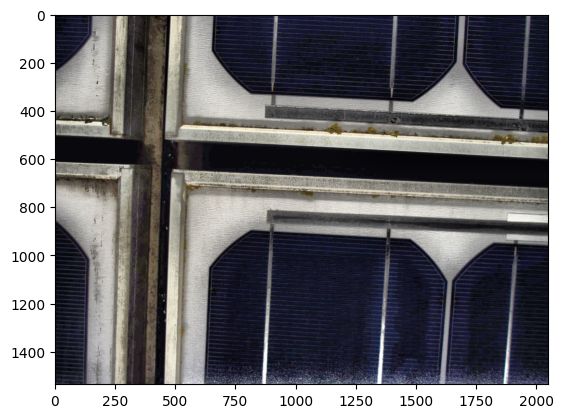

In [14]:
import skimage

def process_image(image, equalize=True, clip_limit=0.05, gamma=None, rescale=True):
    from skimage import exposure, img_as_float, img_as_ubyte

    if image.dtype == np.uint8:
     image = img_as_float(image)
           
    if equalize:
        image = exposure.equalize_adapthist(image, clip_limit=clip_limit, nbins=96)
    if gamma is not None:
        image = exposure.adjust_gamma(image, gamma)
    if rescale:
      image = exposure.rescale_intensity(image)
    return img_as_ubyte(image)

img = Image.open("/home/shiva/Documents/code/pvdetects/data/Archives_Inspection/10M91204730_CONFORME/panel_0018/Cam 0_10587.jpg")
print(np.array(img).shape)
processed_img = process_image(np.array(img))
plt.imshow(processed_img)


(256, 256)


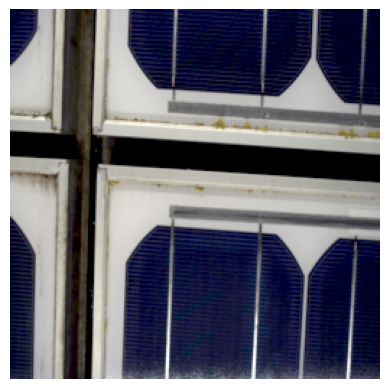

In [26]:
img = Image.open("/home/shiva/Documents/code/pvdetects/data/Archives_Inspection/10M91204730_CONFORME/panel_0018/Cam 0_10587.jpg")
#img = F.to_pil_image(data["image"][0].clone())
transformed_img = transform(img)
transformed_pil_img = ToPILImage()(transformed_img)
print(transformed_pil_img.size)

plt.imshow(transformed_pil_img)
plt.axis('off')  # Hide axes
plt.show()


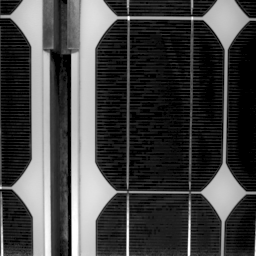

In [16]:
# Image visualization after transformation
img = F.to_pil_image(data["image"][0].clone())

Image.fromarray(np.array(img))

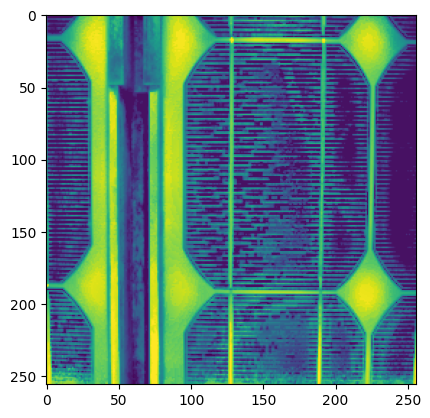

In [17]:
processed_img = process_image(np.array(img))
plt.imshow(processed_img)


As can be seen above, when we choose `classification` task and `train` split, the dataset only returns `image`. This is mainly because training only requires normal images and no labels. Now let's try `test` split for the `classification` task


In [18]:
# Folder Classification Test Set
folder_dataset_classification_test = FolderDataset(
    name="conform_3",
    normal_dir=dataset_root / "good",
    abnormal_dir=dataset_root / "bad",
    split="test",
    transform=transform,
    task=TaskType.CLASSIFICATION,
)
folder_dataset_classification_test.samples.head()

,image_path,label,label_index,mask_path,split
0,/home/shiva/Documents/code/anomalib/datasets/c...,DirType.ABNORMAL,1,,Split.TEST
1,/home/shiva/Documents/code/anomalib/datasets/c...,DirType.ABNORMAL,1,,Split.TEST
2,/home/shiva/Documents/code/anomalib/datasets/c...,DirType.ABNORMAL,1,,Split.TEST


In [19]:
data = folder_dataset_classification_test[0]
print(data.keys(), data["image"].shape, data["image_path"], data["label"])

dict_keys(['image_path', 'label', 'image']) torch.Size([3, 256, 256]) /home/shiva/Documents/code/anomalib/datasets/conform_3/bad/3d996105-Cam_4_43857.jpg 1
